# Tutorial 3. Predictive Modeling

In this notebook we will cover the following:

1. [Building a linear classifier using Support Vector Machines](#SVMs)
2. [Building a nonlinear classifier using SVMs](#nlSVMs)
3. [Tackling class imblance](#imblance)
4. [Extracting confidence measurements](#confidence)
5. [Finding optimal hyperparameters for SVMs](#optimal)
6. [Building an event predictor](#event)
7. [Estimating traffic](#report)

**Predictive modeling** is commonly used in areas of data mining to forecast future trends. It is an analysis that is used to predict the future behavior, by identifying relationship between independent input variables and the target responses. Need to have data with known responses to train the model, and validate using common metrics, and use it to predict future values.

Will use **Support Vector Machines** to build both linear and nonlinear models.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

## 3.1 Building a linear classifier using Support Vector Machines (SVMs) <a class="anchor" id="SVMs"></a>

SVMs are supervised learning models that are used to build classifiers and regresors. Finds the best separating boundary between the two sets of points. Detects and exploits complex patterns in data (by clustering, classifying, ranking, cleaning, etc. the data).

Load in the *data_multivar.txt* and examine it.

In [2]:
data = pd.read_csv('data_multivar.txt',names=['x1','x2','y'])
data.head()

,x1,x2,y
0,5.35,4.48,0
1,6.72,5.37,0
2,3.57,5.25,0
3,4.77,7.65,1
4,2.25,4.07,1


Plot data by class y=0,1

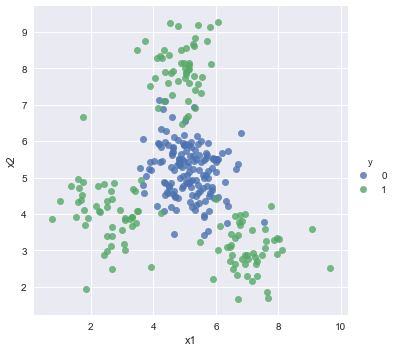

In [3]:
sns.lmplot(data=data,x='x1',y='x2',hue='y',fit_reg=False)

We wish to build a model that can separate the two classes shown above.

In [4]:
from sklearn import cross_validation
from sklearn.svm import SVC
# Separate into training and test
X = data.drop(['y'],axis=1); y = data.y
Xtrain,Xtest,ytrain,ytest = cross_validation.train_test_split(X,y,test_size=0.25,random_state=5)

params = {'kernel':'linear'}
clf = SVC(**params)
clf.fit(Xtrain,ytrain)
ypred_test = clf.predict(Xtest)
ypred_train = clf.predict(Xtrain)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Plot classifier and test results using same function we developed in last chapter.

In [5]:
def classifier_boundary_2d(classifier,X):
    step_size = 0.01
    maxs  = X.max()
    mins  = X.min()
    x1,x2 = np.meshgrid(np.arange(mins.x1 -1,maxs.x1+1,step_size), np.arange(mins.x2-1,maxs.x2+1,step_size))
    output = classifier.predict(np.c_[x1.ravel(),x2.ravel()])
    output = output.reshape(x1.shape)
    return x1,x2,output

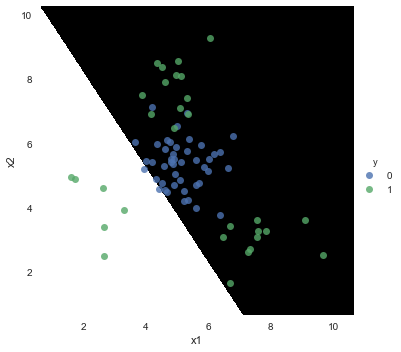

In [6]:
# Plotting
datatest = Xtest.copy();datatest['y'] =ytest
x1,x2,output = classifier_boundary_2d(clf,Xtest)
sns.lmplot("x1", "x2", data=datatest, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)

Can see above that it does not do a great job with the test data. Let's look at classification report:

Train data

In [7]:
from sklearn.metrics import classification_report
print(classification_report(ytrain,ypred_train,target_names=['class0','class1']))

             precision    recall  f1-score   support

     class0       0.55      0.88      0.68       105
     class1       0.78      0.38      0.51       120

avg / total       0.67      0.61      0.59       225



Test data

In [8]:
print(classification_report(ytest,ypred_test,target_names=['class0','class1']))

             precision    recall  f1-score   support

     class0       0.64      0.96      0.77        45
     class1       0.75      0.20      0.32        30

avg / total       0.69      0.65      0.59        75



Obviously we cannot use a linear classifier for our data by looking at the results above, need a non-linear classifier.

## 3.2 Building a nonlinear classifier using SVMs <a class="anchor" id="nlSVMs"></a>

We want to represent a curvy boundary between two sets of points, we can do this using polynomail function or a radial basis function.

### Polynomial kernel

Training report:
             precision    recall  f1-score   support

     class0       0.92      0.84      0.88       105
     class1       0.87      0.93      0.90       120

avg / total       0.89      0.89      0.89       225

Test report:
             precision    recall  f1-score   support

     class0       0.91      0.87      0.89        45
     class1       0.81      0.87      0.84        30

avg / total       0.87      0.87      0.87        75



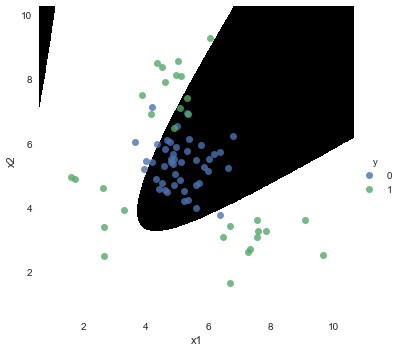

In [9]:
params={'kernel':'poly','degree':3}
clf_poly = SVC(**params)
clf_poly.fit(Xtrain,ytrain)
ypolypred_test = clf_poly.predict(Xtest)
ypolypred_train = clf_poly.predict(Xtrain)
#Plotting
x1,x2,output = classifier_boundary_2d(clf_poly,Xtest)
sns.lmplot("x1", "x2", data=datatest, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)
print('Training report:')
print(classification_report(ytrain,ypolypred_train,target_names=['class0','class1']))
print('Test report:')
print(classification_report(ytest,ypolypred_test,target_names=['class0','class1']))

Can see above it does a better job than the linear kernel, you can play around with changing the degree of the polynomial and how it affects train/test classification.

### Radial kernel

Training report:
             precision    recall  f1-score   support

     class0       0.95      0.98      0.97       105
     class1       0.98      0.96      0.97       120

avg / total       0.97      0.97      0.97       225

Test report:
             precision    recall  f1-score   support

     class0       0.95      0.93      0.94        45
     class1       0.90      0.93      0.92        30

avg / total       0.93      0.93      0.93        75



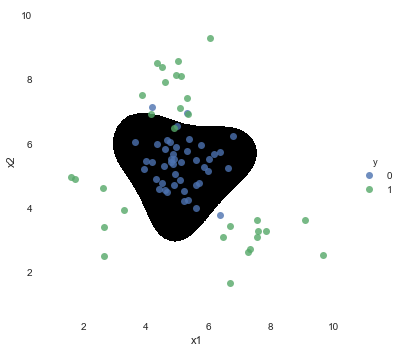

In [10]:
params={'kernel':'rbf'}
clf_rad = SVC(**params)
clf_rad.fit(Xtrain,ytrain)
yradpred_test = clf_rad.predict(Xtest)
yradpred_train = clf_rad.predict(Xtrain)
#Plotting
x1,x2,output = classifier_boundary_2d(clf_rad,Xtest)
sns.lmplot("x1", "x2", data=datatest, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)
print('Training report:')
print(classification_report(ytrain,yradpred_train,target_names=['class0','class1']))
print('Test report:')
print(classification_report(ytest,yradpred_test,target_names=['class0','class1']))

Radial function kernel gives the highest of the 3, but you can see is a larger delta between train and test data than for linear & polynomial.

## 3.3 Tackling class imbalance <a class="anchor" id="imbalance"></a>
We have only delt with problems that have had similar number of datapoints in all the classes. In reality data might not be available like this, and data in one class heavily outnumbers another class. The problem is that the classifier can be biased towards the class with larger observations, and the resulting boundary will not reflect the true nature of the data. We have to account for this.

Load in dataset *data_multivar_imbalance.txt*

,x1,x2,y
0,5.35,4.48,0
1,6.72,5.37,0
2,3.57,5.25,0
3,4.77,7.65,1
4,2.25,4.07,1


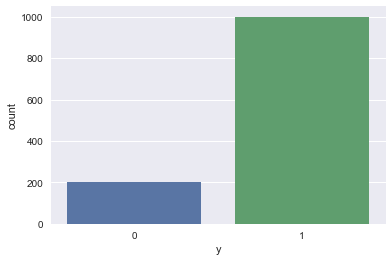

In [11]:
datai = pd.read_csv('data_multivar_imbalance.txt',names=['x1','x2','y'])
display(data.head())
sns.countplot(x="y", data=datai)

We see that there is 5x more 1's than 0's in the dataset. Let's visualize the dataset and try to use the linear SVM we developed earlier.

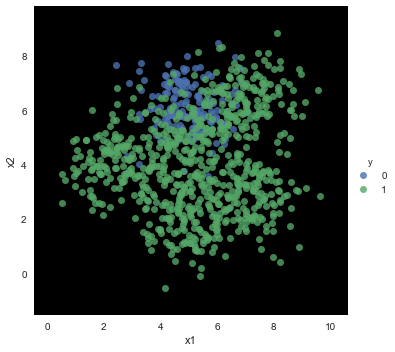

In [12]:
# Seperate into train and test
X = datai.drop(['y'],axis=1); y = datai.y
Xtrain,Xtest,ytrain,ytest = cross_validation.train_test_split(X,y,test_size=0.25,random_state=5)
datatest = Xtest.copy();datatest['y']=ytest
datatrain= Xtrain.copy();datatrain['y']=ytrain
# Build linear SVM model
params = {'kernel':'linear'}
clf = SVC(**params)
clf.fit(Xtrain,ytrain)
ypred_test = clf.predict(Xtest)
ypred_train = clf.predict(Xtrain)
# Plot boundary and training data
x1,x2,output = classifier_boundary_2d(clf,Xtrain)
sns.lmplot("x1", "x2", data=datatrain, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)

From the above, the classifier was unable to separate the two classes. Resulting in 0% accuracy for class0. Can fix this with adding weighting to classifier, to weight by the number of points.

Test report:
             precision    recall  f1-score   support

     class0       0.29      0.76      0.42        42
     class1       0.95      0.70      0.80       258

avg / total       0.86      0.71      0.75       300



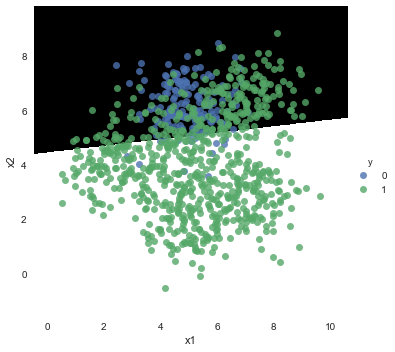

In [13]:
# Build linear SVM model
params = {'kernel':'linear','class_weight':'balanced'}
clf = SVC(**params)
clf.fit(Xtrain,ytrain)
ypred_test = clf.predict(Xtest)
ypred_train = clf.predict(Xtrain)
# Plot boundary and training data
x1,x2,output = classifier_boundary_2d(clf,Xtrain)
sns.lmplot("x1", "x2", data=datatrain, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)
print('Test report:')
print(classification_report(ytest,ypred_test,target_names=['class0','class1']))

Does a better job but still misclassifies a large portion now of class 1. Quckly try a radial kernel model.

Test report:
             precision    recall  f1-score   support

     class0       0.60      0.57      0.59        42
     class1       0.93      0.94      0.93       258

avg / total       0.88      0.89      0.89       300



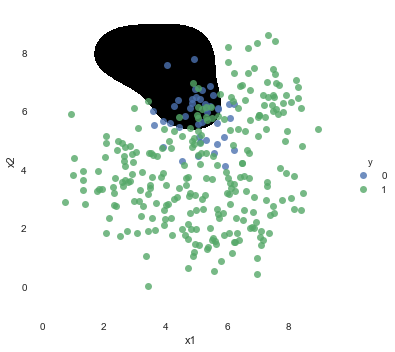

In [14]:
params={'kernel':'rbf'}
clf_rad = SVC(**params)
clf_rad.fit(Xtrain,ytrain)
yradpred_test = clf_rad.predict(Xtest)
#Plotting
x1,x2,output = classifier_boundary_2d(clf_rad,Xtest)
sns.lmplot("x1", "x2", data=datatest, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)
print('Test report:')
print(classification_report(ytest,yradpred_test,target_names=['class0','class1']))

Slightly bettet for class0 now.

## 3.4 Extracting confidence measurements <a class="anchor" id="confidence"></a>
It would be helpful if there was a range of confidence associated with the classified output, so that we know how much uncertainty there is for a classification. SVM in sklearn can do this.

We'll work with the same dataset we had in last section.

Distance from boundary:


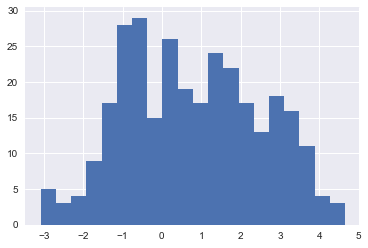

In [15]:
#Use the test data in the last section
print('Distance from boundary:')
hist=plt.hist(clf.decision_function(Xtest),bins=20)

For the test data above we see the distance from the boundary for each point, but does not give confidence. The large positive values are the green dots far away.

We need **Platt scaling** to get probabilities of the classes. Converts the distance measure into probability measure between classes. The probability parameter tells the SVM that it should train to compute probabilities as well.

In [16]:
#Probability measure with test data
params={'kernel':'rbf','probability':True}
clf = SVC(**params)
clf.fit(Xtrain,ytrain)
# Make a dataframe with probabilities
XtestP = Xtest.copy() 
Probs = clf.predict_proba(Xtest)
XtestP['P(0)']= Probs[:,0];XtestP['P(1)']=Probs[:,1]
XtestP.head()

,x1,x2,P(0),P(1)
984,5.70,5.83,0.397293,0.602707
887,7.33,8.58,0.072173,0.927827
11,7.95,5.32,0.072505,0.927495
235,5.70,6.05,0.470885,0.529115
596,3.23,3.92,0.071589,0.928411


Now let's make plots with the probabilities

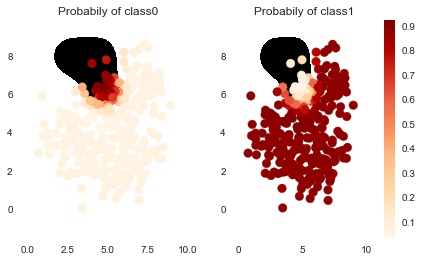

In [17]:
# Plotting
x1,x2,output = classifier_boundary_2d(clf,Xtrain)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[7,4])
p0 = ax1.scatter(XtestP.x1,XtestP.x2,  c=XtestP['P(0)'],cmap=plt.cm.OrRd, s=75)
ax1.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0);ax1.set_title('Probabily of class0')
plt.colorbar(p0)
p1 = ax2.scatter(XtestP.x1,XtestP.x2,  c=XtestP['P(1)'],cmap=plt.cm.OrRd, s=75)
ax2.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0);ax2.set_title('Probabily of class1')

Can where largest area of uncertainity is for the boundary, but know now the probability of each classification point.

## 3.5 Finding optimal hyperparameters for SVMs <a class="anchor" id="optimal"></a>
We'll look at how to find optimal hyperparameters for SVMs.

Reload the *data_multivar.txt* dataset

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

data = pd.read_csv('data_multivar.txt',names=['x1','x2','y'])
data.head()

,x1,x2,y
0,5.35,4.48,0
1,6.72,5.37,0
2,3.57,5.25,0
3,4.77,7.65,1
4,2.25,4.07,1


Split data into train and test dataframes

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2)

Set parameters for grid search and cross-validation

In [20]:
Xtrain = train.drop(['y'],axis=1);ytrain = train.y
Xtest  = test.drop(['y'],axis=1); ytest = test.y

parameter_grid = [  {'kernel': ['linear'], 'C': [1, 10, 50, 600]},
                    {'kernel': ['poly'], 'degree': [2, 3]},
                    {'kernel': ['rbf'], 'gamma': [0.01, 0.001], 'C': [1, 10, 50, 600]},
                 ]

metrics = ['precision', 'recall']

for metric in metrics:
    print('Tuning optimal hyperparameters for: ',metric)
    clf = GridSearchCV(SVC(C=1), parameter_grid, cv=5,
                       scoring='%s_macro' % metric)
    clf.fit(Xtrain,ytrain)

    print("\nBest parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

Tuning optimal hyperparameters for:  precision


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:


Best parameters set found on development set:

{'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.739 (+/-0.100) for {'C': 1, 'kernel': 'linear'}
0.739 (+/-0.100) for {'C': 10, 'kernel': 'linear'}
0.739 (+/-0.100) for {'C': 50, 'kernel': 'linear'}
0.748 (+/-0.093) for {'C': 600, 'kernel': 'linear'}
0.864 (+/-0.094) for {'degree': 2, 'kernel': 'poly'}
0.864 (+/-0.101) for {'degree': 3, 'kernel': 'poly'}
0.842 (+/-0.027) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.252 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.922 (+/-0.077) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.747 (+/-0.118) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.933 (+/-0.063) for {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
0.809 (+/-0.062) for {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}
0.933 (+/-0.075) for {'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}
0.915 (+/-0.063) for {'C': 600, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on

Above we found the best parameters where: kernel = 'rbf' C = 50, gamma = 0.01

Let's plot the best hyperparameter classification:

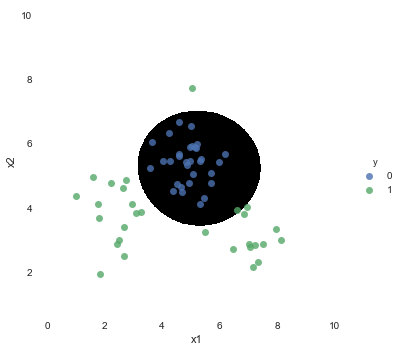

In [21]:
# Plot
x1,x2,output = classifier_boundary_2d(clf,Xtrain)
sns.lmplot("x1", "x2", data=test, hue='y', fit_reg=False)
plt.pcolormesh(x1,x2,output,cmap=plt.cm.gray,zorder=0)

## 3.6 Building an event predictor <a class="anchor" id="event"></a>
We'll build a SVM to predict the number of people going in and out of a building. The dataset is available at https://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts . We are working with a modified version of this dataset so that it's easier to analyze.

The modified data files are:
1. *building_event_binary.txt*
2. *building_event_multiclass.txt*

The features are:
1. Day
2. Date
3. Time
4. The number of people going out of the building
5. The number of people coming into the building

Output:
1. indicating whether or not it's an event or
2. output indicating the type of event

In [22]:
from sklearn import preprocessing 
from sklearn.svm import SVC

Import data:

In [23]:
eventBDF = pd.read_csv('building_event_binary.txt',names=['Day','Date','Time','Nout','Nin','Event'],
                      skipinitialspace=True)
eventBDF.head()

,Day,Date,Time,Nout,Nin,Event
0,Sunday,07/24/05,00:00:00,0,0,noevent
1,Sunday,07/24/05,00:30:00,1,0,noevent
2,Sunday,07/24/05,01:00:00,0,0,noevent
3,Sunday,07/24/05,01:30:00,0,0,noevent
4,Sunday,07/24/05,02:00:00,0,0,noevent


Make some plots

In [24]:
#Map outcome to integer:
emap = {'noevent':0,'event':1}
eventBDF['Event'] = eventBDF.Event.map(emap)

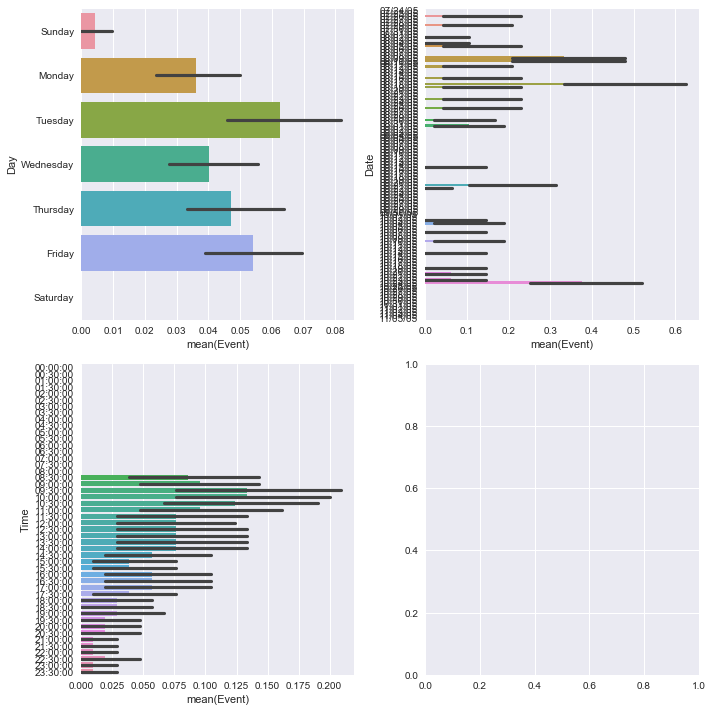

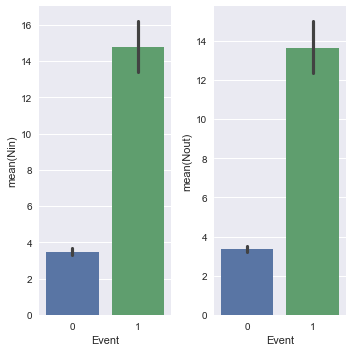

In [25]:
# Plot features
catfeatures = ['Day','Date','Time']
fig,axes=plt.subplots(2,2,figsize=[10,10])
for f,ax in zip(catfeatures,axes.ravel()):
    sns.barplot(x='Event', y=f, data=eventBDF,ax=ax,orient='h')
plt.tight_layout()
fig,axes=plt.subplots(1,2,figsize=[5,5])
sns.barplot(x="Event", y="Nin", data=eventBDF,ax=axes[0])
sns.barplot(x="Event", y="Nout", data=eventBDF,ax=axes[1])
plt.tight_layout()

From the above we see that events don't happen until 8:30 in the morning, which dates they occur on, do not occur on Saturday and less likely on Sunday. When there is an event usually have Nin and Nout around 15.

### Encode labels and split into test and train data

In [26]:
from sklearn.model_selection import train_test_split

edata = eventBDF.copy()
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
edata[catfeatures] = edata[catfeatures].apply(lambda x: d[x.name].fit_transform(x))

train,test = train_test_split(edata,test_size=0.25)
train.head()

,Day,Date,Time,Nout,Nin,Event
1140,5,23,36,9,1,0
2881,4,60,1,0,0,0
577,0,12,1,0,0,0
1499,6,31,11,2,2,0
158,6,3,14,0,2,0


### Build and train classifier 

In [27]:
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

Xtrain = train.drop(['Event'],axis=1);ytrain=train.Event
Xtest  = test.drop(['Event'],axis=1); ytest = test.Event

#Search over parameter grid
parameter_grid = [ {'kernel': ['rbf'], 'gamma': [0.01, 0.001], 'C': [1, 10, 50, 600]},
                 ]

print('Tuning optimal hyperparameters for precision')
clf = GridSearchCV(SVC(C=1,probability=True,class_weight='balanced'),
                   parameter_grid, cv=5, scoring='precision',n_jobs=-1)
clf.fit(Xtrain,ytrain)

print("\nBest parameters set found on development set:")
print(clf.best_params_)
print()
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(Xtest)
print(classification_report(y_true, y_pred))
print('\nAccuracy score: ',accuracy_score(y_true, y_pred))

Tuning optimal hyperparameters for precision

Best parameters set found on development set:
{'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1219
          1       0.38      0.44      0.41        41

avg / total       0.96      0.96      0.96      1260


Accuracy score:  0.95873015873


We can see from the above the classifier does well for no-events, but not as great for events.

### Repeat with multi-event data

In [28]:
eventMDF = pd.read_csv('building_event_multiclass.txt',names=['Day','Date','Time','Nout','Nin','Event'],
                      skipinitialspace=True)
display( eventMDF.head() )
eventMDF.Event.unique()

,Day,Date,Time,Nout,Nin,Event
0,Tuesday,07/26/05,11:30:00,9,26,eventA
1,Tuesday,07/26/05,12:00:00,8,13,eventA
2,Tuesday,07/26/05,12:30:00,6,3,eventA
3,Tuesday,07/26/05,13:00:00,25,12,eventA
4,Tuesday,07/26/05,13:30:00,12,12,eventA


array(['eventA', 'eventC', 'eventB'], dtype=object)

There are three different event types 'A' 'B' and 'C'

In [29]:
#Map events to integer:
emap = {'eventA':0,'eventB':1,'eventC':2}
eventMDF['Event'] = eventMDF.Event.map(emap)
eventMDF.head()

,Day,Date,Time,Nout,Nin,Event
0,Tuesday,07/26/05,11:30:00,9,26,0
1,Tuesday,07/26/05,12:00:00,8,13,0
2,Tuesday,07/26/05,12:30:00,6,3,0
3,Tuesday,07/26/05,13:00:00,25,12,0
4,Tuesday,07/26/05,13:30:00,12,12,0


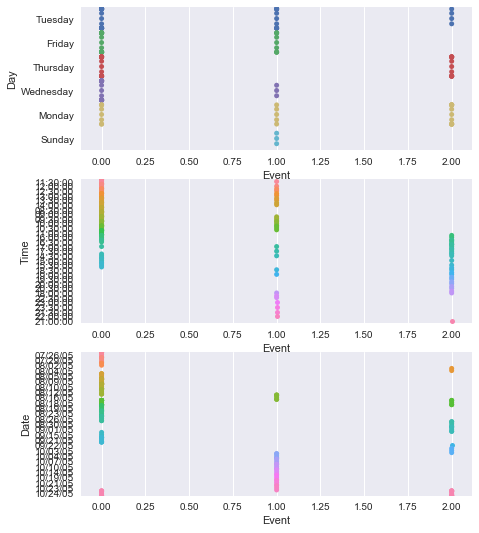

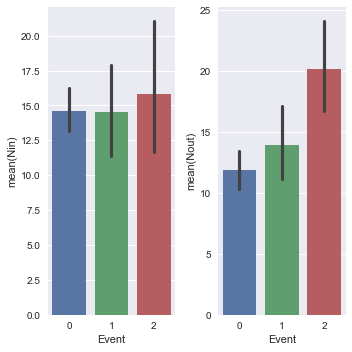

In [30]:
#Make a few plots:
fig,axes = plt.subplots(3,1,figsize=[7,9])
for feat,ax in zip( ['Day','Time','Date'],axes.ravel()):
    sns.swarmplot(x="Event", y=feat, data=eventMDF,ax=ax)
fig,axes=plt.subplots(1,2,figsize=[5,5])
sns.barplot(x="Event", y="Nin", data=eventMDF,ax=axes[0])
sns.barplot(x="Event", y="Nout", data=eventMDF,ax=axes[1])
plt.tight_layout()

Encode features

In [31]:
edata = eventMDF.copy()
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
edata[catfeatures] = edata[catfeatures].apply(lambda x: d[x.name].fit_transform(x))
train,test = train_test_split(edata,test_size=0.2)
train.head()

,Day,Date,Time,Nout,Nin,Event
1,4,0,7,8,13,0
86,3,9,22,16,10,2
150,5,23,29,6,6,1
115,3,14,16,16,9,2
109,4,13,18,13,4,2


Build classifier

In [32]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

Xtrain = train.drop(['Event'],axis=1);ytrain=train.Event
Xtest  = test.drop(['Event'],axis=1); ytest = test.Event

#Use multiclass classifier
parameter_grid = [ {'kernel': ['rbf'], 'gamma': [0.01, 0.001], 'C': [1, 10, 50, 600]},
                 ]

print('Tuning optimal hyperparameters for precision')
clf = GridSearchCV(SVC(C=1,probability=True,class_weight='balanced'),
                   parameter_grid, cv=5, scoring='accuracy',n_jobs=-1)
clf.fit(Xtrain,ytrain)

print("\nBest parameters set found on development set:")
print(clf.best_params_)
print()
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(Xtest)
print(classification_report(y_true, y_pred))
print('\nAccuracy score: ',accuracy_score(y_true, y_pred))

Tuning optimal hyperparameters for precision

Best parameters set found on development set:
{'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.79      0.96      0.87        24
          1       0.50      0.20      0.29         5
          2       0.60      0.43      0.50         7

avg / total       0.71      0.75      0.72        36


Accuracy score:  0.75


Can see it does well for eventA but not great for B and C.

## 3.7 Estimating traffic <a class="anchor" id="traffic"></a>

Can use SVMs to predict traffic based on related data. In this example we will use SVM as a regressor instead of a classifier that we used in the previous exmaples.

Data is available at https://archive.ics.uci.edu/ml/datasets/Dodgers+Loop+Sensor and also found in file *traffic_data.txt*. This loop sensor data was collected for the Glendale on ramp for the 101 North freeway in Los Angeles. It is close enough to the stadium to see unusual traffic after a Dodgers game, but not so close and heavily used by game traffic so that the signal for the extra traffic is overly obvious. 

The features in the dataset are:
    * Day
    * Time
    * Opponent team
    * If baseball game is happening or not
    * Number of cars passing by
    
### Import data

In [33]:
from sklearn.svm import SVR #regressor
trafficDF = pd.read_csv('traffic_data.txt',names=['Day','Time','Opponent','GameOn','Ncars'])
trafficDF.head()

,Day,Time,Opponent,GameOn,Ncars
0,Tuesday,00:00,San Francisco,no,3
1,Tuesday,00:05,San Francisco,no,8
2,Tuesday,00:10,San Francisco,no,10
3,Tuesday,00:15,San Francisco,no,6
4,Tuesday,00:20,San Francisco,no,1


### Make a few plots

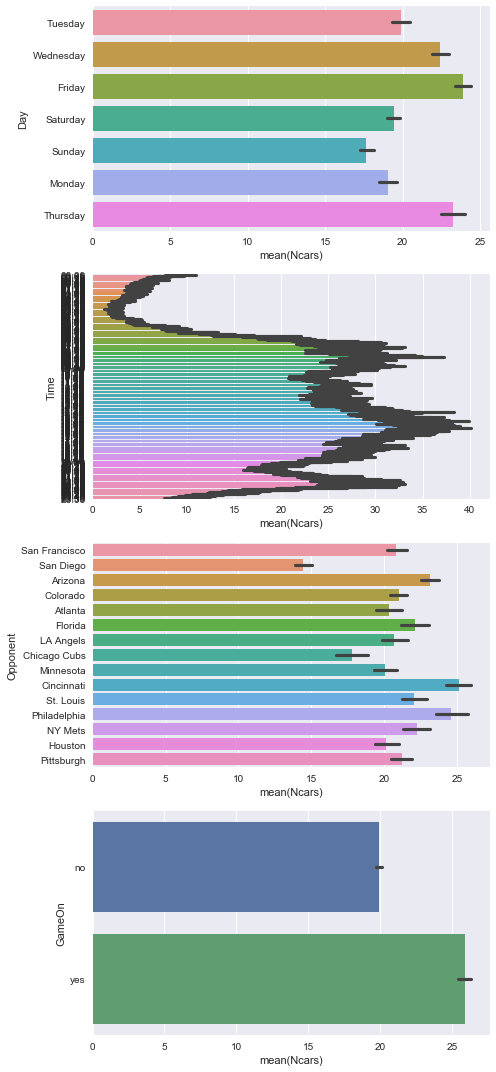

In [34]:
catfeatures = ['Day','Time','Opponent','GameOn']
fig,axes = plt.subplots(4,1,figsize=[7,15])
for feat,ax in zip( catfeatures,axes.ravel()):
    sns.barplot(x="Ncars", y=feat, data=trafficDF,ax=ax,orient='h')
plt.tight_layout()

### Encode the data

In [35]:
tdata = trafficDF.copy()
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
tdata[catfeatures] = tdata[catfeatures].apply(lambda x: d[x.name].fit_transform(x))

train,test = train_test_split(tdata,test_size=0.20)
train.head()

,Day,Time,Opponent,GameOn,Ncars
1186,3,34,12,0,7
590,0,14,12,0,5
1433,3,281,12,0,3
9186,1,258,3,0,56
6726,3,102,8,0,12


### Build regressor 
Search over parameters for regression

In [36]:
import time
Xtrain = train.drop(['Ncars'],axis=1);ytrain = train.Ncars
Xtest  = test.drop(['Ncars'],axis=1); ytest  = test.Ncars

parameter_grid = [{'gamma': [0.01, 0.001,], 'C': [1,10,50],
                   'epsilon':[0.01,0.1,]},
                 ]
svr = GridSearchCV(SVR(kernel='rbf'), cv=5, param_grid= parameter_grid,n_jobs=-1)
t0 = time.time()
svr.fit(Xtrain,ytrain)
svr_fit = time.time() - t0
print("SVR model fitted in %.3f s" % svr_fit)
ypred = svr.predict(Xtest)

SVR model fitted in 134.469 s


In [37]:
import sklearn.metrics as sm
def evaluate_model(ytest,ypred_test):
    metrics = pd.DataFrame({'Metric':['Mean absolute error','Mean squared error','Median absolute error','Explained variance','R2score']})
    metricvals=[]
    # Mean absolute error
    metricvals.append(round( sm.mean_absolute_error(ytest,ypred_test),2))
    # Mean squared error
    metricvals.append(round( sm.mean_squared_error(ytest,ypred_test),2))
    # Median absolute error
    metricvals.append(round(sm.median_absolute_error(ytest,ypred_test),2))
    # Explained variance
    metricvals.append(round(sm.explained_variance_score(ytest,ypred_test),2))
    # R2score
    metricvals.append(round(sm.r2_score(ytest,ypred_test),2))
    metrics['Values'] = metricvals
    return metrics
print("\nBest parameters set found on development set:")
print()
print(svr.best_params_)
evaluate_model(ytest,ypred)


Best parameters set found on development set:

{'C': 50, 'epsilon': 0.1, 'gamma': 0.01}


,Metric,Values
0,Mean absolute error,6.05
1,Mean squared error,78.34
2,Median absolute error,4.01
3,Explained variance,0.62
4,R2score,0.62


Let's make a plot of true vs predicted

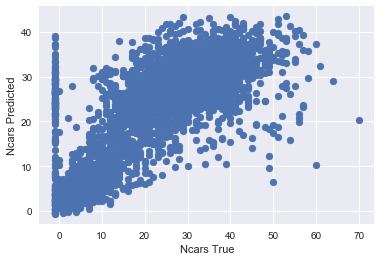

In [38]:
plt.figure()
plt.scatter(ytest,ypred);plt.xlabel('Ncars True');plt.ylabel('Ncars Predicted')

Can see that the area the regressor struggles the most is to predict 0 cars.